In [1]:
# import qutip packages
import qutip
import krotov

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import numpy.random as rnd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

# Two-Level System (Qubit) Optimization State Transfer 

We first consider a simple two-level system.  We can represent our time-dependent Hamiltonian as $\hat{H}(t) = \hat{H}_0 + \hat{H}_1(t)$ where $\hat{H}_0 = -\frac{\omega}{2}\hat{\sigma}_z$ (a simple qubit with $E_1 - E_0 = \hbar \omega = \omega$, taking units e = $\hbar$ = 1.

We know that when a system interacts with a laser pulse $\epsilon(t)$, the interaction with the light field is described by the time-dependent interaction Hamiltonian $H_1(t) = -\mu \cdot \epsilon(t) \hat{\sigma}_x (t) = \mu_{01} \epsilon(t)\hat{\sigma}_x (t)$, assuming the transition dipole moment to be real. We wish to control the laser pulse for optimization of a target. So, we can represent $H_1(t) = f(t) \hat{\sigma}_x(t)$ for an arbitrary function $f(x)$. This will serve as our "control field" into our optimization problem that is coupled to the qubit.  


In this simulation, we wish to find $f(t)$ such that it drives transitions between the two states.

In [20]:
def hamiltonian(omega=1.0, amp=0.1):
    
    # omega = energy separation between two states 
    # amplitude of the control field
    """Two-level-system Hamiltonian

    Args:
        omega (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
    """
    H0 = -0.5 * omega * qutip.operators.sigmaz()
    
    
    # guess the control function 
    def control_guess(t, args):
        return krotov.shapes.blackman(t, t_start = 0.0, t_stop = 5.0)
    
    H1 = amp * qutip.operators.sigmax()

    return [H0, [H1, control_guess]]


We choose the initial guess for the control function to be a simple Blackman shape/window function (simple Gaussian), but zero-valued outside a chosen interval.   Blackman pulses are commonly used for QOC and for different applications because of their suppression of sidelobes in the Fourier domain.  

In [21]:
H = hamiltonian()

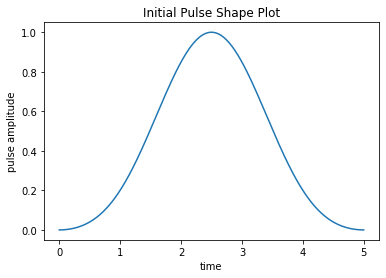

In [29]:
# plot the pulse

def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    ax.set_title('Initial Pulse Shape Plot')
    plt.show(fig)
    
tlist = np.linspace(0, 5, 500)    
plot_pulse(H[1][1], tlist)

Suppose that our target state is state-to-state transfer from an initial state ih the ground state $|\Psi_0>$ to the target state in the excited state $|\Psi_1>$ for the time-dependent Hamiltonian defined previously. 

We first simulate the dynamics of the time-dependent system under this initial guess field. We use the projects $\hat{P}_0 = |0><0|$ and $\hat{P}_1 = |1><1|$ to calculate the population and then plot the population dynamics.  Dynamics are computed using time-dependent perturbation calculations.

In [35]:
proj0 = qutip.ket2dm(qutip.ket("0"))
proj1 = qutip.ket2dm(qutip.ket("1"))

guess_dynamics = objectives[0].mesolve(tlist, e_ops=[proj0, proj1])

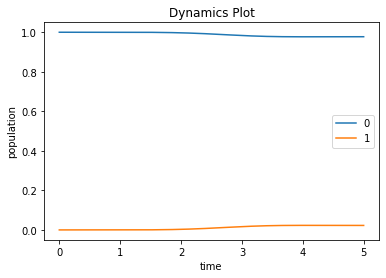

In [42]:
# plot population 

def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    ax.set_title('Dynamics Plot')
    plt.show(fig)
    
plot_population(guess_dynamics)

We now optimize the pulse to achieve our objective using the Krotov optimization methods/routines.  We wish to optimize our control field $f(t)$ such that we achieve our target objective (state transfer).  There are a few variables that go into this optimization.  It requires the objectives, information about the optimization functional $J_T$.  

In this problem, we define $J_T = 1 - F_{ss} = 1 - |< \Psi_1 | \Psi(T)>|^2$, with $|\Psi(T)>$ be the forward propagated state of $|\Psi_0>$. 

The optimization stops when $J_T$ falls below $10^{-3}$, changes by less than $10^{-5}$, or after at most 15 iterations.  Printing $J_T$ allows us to check on the optimization procedure and monotonic convergence.

In [30]:
# set the optimization objective 

objectives = [
    krotov.Objective(
        initial_state=qutip.ket("0"), target=qutip.ket("1"), H=H
    )
]

objectives

[Objective[|Ψ₀(2)⟩ to |Ψ₁(2)⟩ via [H₀[2,2], [H₁[2,2], u₁(t)]]]]

We set a function $S(t)$ that updates the shape of the pulse at each point in time proportionally to $S(t)$; this helps maintain the property of the control field to be zero in the assigned interval.  We also take in a parameter $\lambda_a$ such that it determines the overall magnitude of the field in each iteration (small $\lambda$ means larger update, proportional to $S(t)/\lambda_a$.  These parameters are passed into the optimization routine.

In [31]:
def S(t):
    # Scales the Krotov methods update of the pulse value at the time t
    return krotov.shapes.flattop(
        t, t_start=0.0, t_stop=5.0, t_rise=0.3, func='sinsq'
    )

In [32]:
pulse_options = {
    H[1][1]: dict(lambda_a=0.5, update_shape=S)
}


In [37]:
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_ss,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error,
    ),
    store_all_pulses=True,
)

iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     9.77e-01    0.00e+00   9.77e-01        n/a        n/a     3
1     9.76e-01    1.59e-03   9.77e-01  -1.65e-03  -6.27e-05     4
2     9.74e-01    1.70e-03   9.76e-01  -1.77e-03  -6.71e-05     3
3     9.72e-01    1.82e-03   9.74e-01  -1.89e-03  -7.18e-05     4
4     9.70e-01    1.95e-03   9.72e-01  -2.03e-03  -7.68e-05     3
5     9.68e-01    2.08e-03   9.70e-01  -2.17e-03  -8.21e-05     4
6     9.65e-01    2.23e-03   9.68e-01  -2.32e-03  -8.78e-05     3
7     9.63e-01    2.38e-03   9.65e-01  -2.48e-03  -9.38e-05     4
8     9.60e-01    2.54e-03   9.63e-01  -2.64e-03  -1.00e-04     5
9     9.58e-01    2.72e-03   9.60e-01  -2.82e-03  -1.07e-04     5
10    9.55e-01    2.90e-03   9.57e-01  -3.01e-03  -1.14e-04     5
11    9.51e-01    3.09e-03   9.54e-01  -3.22e-03  -1.22e-04     7
12    9.48e-01    3.30e-03   9.51e-01  -3.43e-03  -1.30e-04     7
13    9.44e-01    3.52e-03   9.48e-01  -3.66e-03  -1.38e-04     6
14    9.40

124   1.20e-02    6.97e-04   1.27e-02  -7.24e-04  -2.74e-05     5
125   1.13e-02    6.57e-04   1.19e-02  -6.83e-04  -2.59e-05     5
126   1.06e-02    6.19e-04   1.13e-02  -6.44e-04  -2.44e-05     6
127   1.00e-02    5.84e-04   1.06e-02  -6.07e-04  -2.31e-05     5
128   9.45e-03    5.51e-04   1.00e-02  -5.72e-04  -2.18e-05     4
129   8.91e-03    5.19e-04   9.43e-03  -5.40e-04  -2.05e-05     6
130   8.41e-03    4.89e-04   8.89e-03  -5.09e-04  -1.94e-05     4
131   7.93e-03    4.62e-04   8.39e-03  -4.80e-04  -1.83e-05     4
132   7.47e-03    4.35e-04   7.91e-03  -4.52e-04  -1.73e-05     4
133   7.05e-03    4.10e-04   7.46e-03  -4.27e-04  -1.63e-05     4
134   6.64e-03    3.87e-04   7.03e-03  -4.02e-04  -1.54e-05     4
135   6.27e-03    3.65e-04   6.63e-03  -3.79e-04  -1.45e-05     5
136   5.91e-03    3.44e-04   6.25e-03  -3.57e-04  -1.37e-05     4
137   5.57e-03    3.24e-04   5.89e-03  -3.37e-04  -1.29e-05     4
138   5.25e-03    3.06e-04   5.56e-03  -3.18e-04  -1.22e-05     6
139   4.95

In [38]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2020-09-07 21:24:59
- Number of objectives: 1
- Number of iterations: 167
- Reason for termination: Reached convergence: J_T < 1e-3
- Ended at 2020-09-07 21:43:43 (0:18:44)

Once we achieve the optimized result, we simulate the system dynamical evolution again to verify that the target state is achieved with the optimized pulse. 

In [40]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj0, proj1])

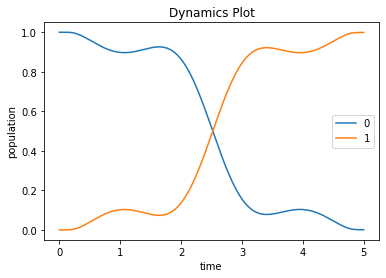

In [43]:
plot_population(opt_dynamics)

We also plot the optimization from the initial pulse shape. 

In [44]:
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """
    fig, [ax_ctr, ax_dyn] = plt.subplots(nrows=2, figsize=(8, 10))
    n_iters = len(opt_result.iters)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=[proj0, proj1]
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = ['0 (guess)', '1 (guess)']
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = ['0 (optimized)', '1 (optimized)']
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None, None]
        ax_ctr.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[0],
            label=pop_labels[0],
            color='#1f77b4',  # default blue
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[1],
            label=pop_labels[1],
            color='#ff7f0e',  # default orange
            ls=ls,
            alpha=alpha,
        )
    ax_dyn.legend()
    ax_dyn.set_xlabel('time')
    ax_dyn.set_ylabel('population')
    ax_ctr.legend()
    ax_ctr.set_xlabel('time')
    ax_ctr.set_ylabel('control amplitude')
    plt.show(fig)

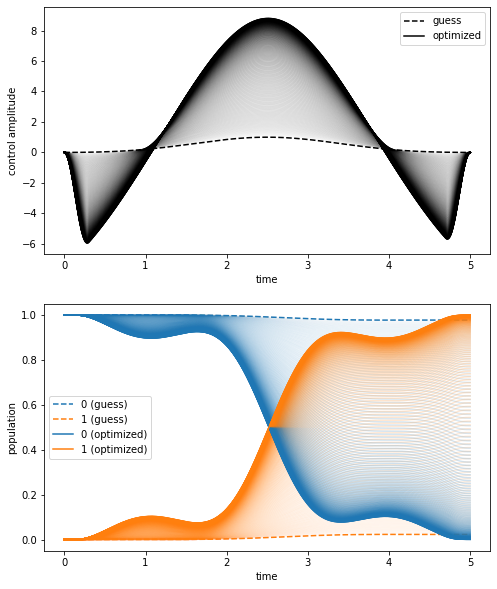

In [45]:
plot_iterations(opt_result)